In [25]:
import sqlite3, json
import pandas as pd

# 1. Connect to the database
conn = sqlite3.connect('valorant_esports.db')

# 2. Use a SQL query to fetch data directly into a DataFrame
# query = "SELECT * FROM series"
query = "SELECT * FROM teams"
team_table_final = pd.read_sql_query(query, conn)

team_table_final['weaponKills'] = team_table_final['weaponKills'].apply(json.loads)
team_table_final['player1'] = team_table_final['player1'].apply(json.loads)
team_table_final['player2'] = team_table_final['player2'].apply(json.loads)
team_table_final['player3'] = team_table_final['player3'].apply(json.loads)
team_table_final['player4'] = team_table_final['player4'].apply(json.loads)
team_table_final['player5'] = team_table_final['player5'].apply(json.loads)

# 3. Close the connection
conn.close()

# team_table_final.info()

In [26]:
import json
jsn = team_table_final.drop(columns=['index']).head(1)
jsn.to_json("./json/team.json", orient="records", indent=4)

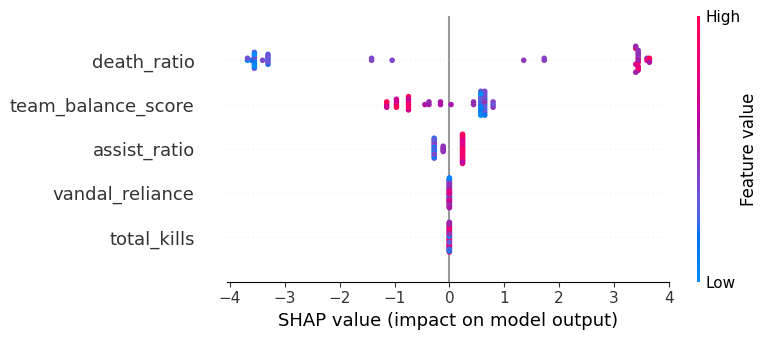

In [27]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import shap

# 1. FLATTENING FUNCTION
def extract_team_features(row):
    # Extract weapon counts
    weapons = {w['weaponName']: w['count'] for w in row['weaponKills']}
    
    # Extract individual player kills
    p_kills = [row[f'player{i}']['kills'] for i in range(1, 6) if f'player{i}' in row]
    
    return pd.Series({
        'total_kills': row['kills'],
        'death_ratio': row['kills'] / (row['deaths'] + 1),
        'vandal_reliance': weapons.get('vandal', 0) / (row['kills'] + 1),
        'team_balance_score': np.std(p_kills), # Lower is more balanced
        'assist_ratio': row['killAssistsGiven'] / (row['kills'] + 1)
    })

# 2. TRANSFORM
X = team_table_final.apply(extract_team_features, axis=1)
y = team_table_final['won'] # Target variable

# 3. TRAIN & EXPLAIN (Identifying Weaknesses)
model = XGBClassifier().fit(X, y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Visualize the 'Weaknesses' for the first team
shap.summary_plot(shap_values, X)

In [28]:
def get_scouting_report_data(team_id, df, X, shap_values, explainer):
    """
    Returns a JSON string of team stats and AI impacts for an LLM prompt.
    """
    # 1. Find the index of the team in your feature matrix X
    # Assuming team_id is a column in your original df
    try:
        idx = df[df['team_id'] == team_id].index[0]
    except IndexError:
        return f"Team ID {team_id} not found."

    # 2. Extract SHAP values for this specific team (local explanation)
    # If binary classification, SHAP usually returns a list [neg_values, pos_values]
    # We want pos_values (index 1) which represent impact on "Winning"
    local_shap = shap_values[1][idx] if isinstance(shap_values, list) else shap_values[idx]
    
    # 3. Pair feature names with their actual values and their SHAP impact
    report = {
        "team_name": df.iloc[idx].get('name', 'Unknown'),
        "prediction_base_value": float(explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value),
        "features": []
    }

    for i, col in enumerate(X.columns):
        report["features"].append({
            "feature": col,
            "actual_value": float(X.iloc[idx][col]),
            "impact_on_win_chance": round(float(local_shap[i]), 4)
        })

    # Sort by absolute impact to show the LLM the most important things first
    report["features"] = sorted(report["features"], key=lambda x: abs(x["impact_on_win_chance"]), reverse=True)

    return json.dumps(report, indent=2)

# --- HOW TO USE --- 
# team_data = get_team_scouting_report_data("81", team_table_final, model, explainer)
team_data = get_scouting_report_data("81", team_table_final, X, shap_values, explainer)
print(team_data)

{
  "team_name": "MIBR (1)",
  "prediction_base_value": -0.011273219250142574,
  "features": [
    {
      "feature": "death_ratio",
      "actual_value": 0.9707602339181286,
      "impact_on_win_chance": -1.418
    },
    {
      "feature": "team_balance_score",
      "actual_value": 9.15204895091804,
      "impact_on_win_chance": -1.1428
    },
    {
      "feature": "assist_ratio",
      "actual_value": 0.47904191616766467,
      "impact_on_win_chance": 0.2407
    },
    {
      "feature": "total_kills",
      "actual_value": 166.0,
      "impact_on_win_chance": 0.0
    },
    {
      "feature": "vandal_reliance",
      "actual_value": 0.30538922155688625,
      "impact_on_win_chance": 0.0
    }
  ]
}


In [98]:
import numpy as np
import pandas as pd
from collections import defaultdict
import math
import shap

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def weapon_entropy(weapon_kills: dict):
    total = sum(weapon_kills.values())
    if total == 0:
        return 0
    entropy = 0
    for v in weapon_kills.values():
        p = v / total
        entropy -= p * math.log(p + 1e-9)
    return entropy

def weapon_usage_stats(weapon_kills):
    stats = {}

    if not weapon_kills:
        return {
            "most_used_weapon": None,
            "least_used_weapon": None,
            "top_weapon_ratio": 0,
            "least_weapon_ratio": 0
        }

    total_kills = sum(weapon_kills.values())

    sorted_weapons = sorted(
        weapon_kills.items(),
        key=lambda x: x[1],
        reverse=True
    )

    most_used_weapon, most_count = sorted_weapons[0]
    least_used_weapon, least_count = sorted_weapons[-1]

    stats["most_used_weapon"] = most_used_weapon
    stats["least_used_weapon"] = least_used_weapon
    stats["top_weapon_ratio"] = most_count / max(total_kills, 1)
    stats["least_weapon_ratio"] = least_count / max(total_kills, 1)
    # print("stats", stats)
    return stats

def weapon_dependency_score(weapon_kills):
    total = sum(weapon_kills.values())
    if total == 0:
        return 0
    return max(weapon_kills.values()) / total

def weapon_class_ratios(weapon_kills):
    rifle = sum(weapon_kills.get(w, 0) for w in ["phantom", "vandal", "guardian"])
    eco = sum(weapon_kills.get(w, 0) for w in ["classic", "ghost", "frenzy", "shorty", "sheriff"])
    sniper = weapon_kills.get("operator", 0)
    smg = sum(weapon_kills.get(w, 0) for w in ["stinger", "spectre"])
    shotgun = sum(weapon_kills.get(w, 0) for w in ["judge", "bucky"])

    total = sum(weapon_kills.values())

    return {
        "rifle_ratio": rifle / max(total, 1),
        "eco_ratio": eco / max(total, 1),
        "sniper_ratio": sniper / max(total, 1),
        "smg_ratio": smg / max(total, 1),
        "shotgun_ratio": shotgun / max(total, 1)
    }

# Overall won teams impact
def compute_weapon_win_impact(team_data):
    weapon_stats = defaultdict(lambda: {"wins": 0, "games": 0})

    for team in team_data:
        won = team["won"]
        for w in team["weaponKills"]:
            weapon = w["weaponName"]
            weapon_stats[weapon]["games"] += 1
            if won:
                weapon_stats[weapon]["wins"] += 1

    weapon_impact = {
        w: weapon_stats[w]["wins"] / max(weapon_stats[w]["games"], 1)
        for w in weapon_stats
    }
    print("weapon_impact", weapon_impact)
    return weapon_impact


def extract_team_features(team_json, weapon_win_impact=None):
    features = {}

    # Basic team stats
    features['series_id'] = team_json['series_id']
    features['team_id'] = team_json['team_id']
    features["kills"] = team_json["kills"]
    features["deaths"] = team_json["deaths"]
    features["kill_diff"] = team_json["kills"] - team_json["deaths"]
    features["assist_density"] = team_json["killAssistsGiven"] / max(team_json["kills"], 1)
    features["assist_received_density"] = team_json["killAssistsReceived"] / max(team_json["kills"], 1)
    features["first_kill"] = team_json["firstKill"]

    # Weapon kills (team level)
    weapon_kills = {}
    for w in team_json["weaponKills"]:
        weapon_kills[w["weaponName"]] = w["count"]

    total_weapon_kills = sum(weapon_kills.values())

    # Usage stats
    usage = weapon_usage_stats(weapon_kills)
    features.update({
        "top_weapon_ratio": usage["top_weapon_ratio"],
        "least_weapon_ratio": usage["least_weapon_ratio"],
        "weapon_dependency": weapon_dependency_score(weapon_kills),
        "weapon_entropy": weapon_entropy(weapon_kills)
    })


    # Weapon class ratios
    features.update(weapon_class_ratios(weapon_kills))

    # Weapon benefit score (weighted by kills)
    if weapon_win_impact:
        benefit = 0
        for weapon, count in weapon_kills.items():
            benefit += count * weapon_win_impact.get(weapon, 0.5)
        features["weapon_benefit_score"] = benefit / max(total_weapon_kills, 1)
    else:
        features["weapon_benefit_score"] = 0.5

    features["weapon_entropy"] = weapon_entropy(weapon_kills)

    features["rifle_ratio"] = (
        weapon_kills.get("phantom", 0) + weapon_kills.get("vandal", 0)
    ) / max(total_weapon_kills, 1)

    features["awp_dependency"] = weapon_kills.get("operator", 0) / max(total_weapon_kills, 1)
    # Player-level aggregation
    player_kills = []
    player_assists = []
    player_headshots = [] 

    for i in range(1, 6):
        p = team_json.get(f"player{i}")
        if not p:
            continue

        player_kills.append(p["kills"])
        player_assists.append(p["killAssistsGiven"])
        player_headshots.append(p.get("headshots", 0))

    features["avg_player_kills"] = np.mean(player_kills)
    features["max_player_kills"] = np.max(player_kills)
    features["std_player_kills"] = np.std(player_kills)   # star dependency
    features["team_headshot_ratio"] = sum(player_headshots) / max(sum(player_kills), 1) 

    return features

def build_dataset(team_json_list):
    X = []
    y = []

    for team in team_json_list:
        features = extract_team_features(team)
        X.append(features)
        y.append(team["won"])   # LABEL

    return pd.DataFrame(X), np.array(y)

def build_predict_structure(data_json):
    X = []
    features = extract_team_features(data_json)
    X.append(features)
    return pd.DataFrame(X)

def explain_team(model, explainer, X_row):
    shap_vals = explainer.shap_values(X_row)

    impact = dict(zip(X_row.columns, shap_vals[0]))
    sorted_impact = sorted(impact.items(), key=lambda x: abs(x[1]), reverse=True)

    strengths = [f for f, v in sorted_impact if v > 0]
    weaknesses = [f for f, v in sorted_impact if v < 0]

    return strengths, weaknesses
    
def team_strength_score(model, X_row):
    win_prob = model.predict_proba(X_row)[0][1]

    consistency = 1 / (1 + X_row["std_player_kills"].values[0])
    synergy = X_row["assist_density"].values[0]

    return float(round(0.5 * win_prob + 0.3 * consistency + 0.2 * synergy, 3))


def weapon_summary_from_features(X_row):
    return {
        "rifle_ratio": float(round(X_row["rifle_ratio"].values[0], 3)),
        "eco_ratio": float(round(X_row["eco_ratio"].values[0], 3)),
        "sniper_ratio": float(round(X_row["sniper_ratio"].values[0], 3)),
        "smg_ratio": float(round(X_row["smg_ratio"].values[0], 3)),
        "shotgun_ratio": float(round(X_row["shotgun_ratio"].values[0], 3)),
        "weapon_dependency": float(round(X_row["weapon_dependency"].values[0], 3)),
        "weapon_entropy": float(round(X_row["weapon_entropy"].values[0], 3)),
        "weapon_benefit_score": float(round(X_row["weapon_benefit_score"].values[0], 3))
    }

def combat_metrics_from_features(X_row):
    return {
        "kills": int(X_row["kills"].values[0]),
        "deaths": int(X_row["deaths"].values[0]),
        "kill_diff": int(X_row["kill_diff"].values[0]),
        "headshot_ratio": float(round(X_row["team_headshot_ratio"].values[0], 3)),
        "first_kill": int(X_row["first_kill"].values[0])
    }

def teamplay_metrics_from_features(X_row):
    return {
        "assist_density": float(round(X_row["assist_density"].values[0], 3)),
        "avg_player_kills": float(round(X_row["avg_player_kills"].values[0], 2)),
        "kill_distribution_std": float(round(X_row["std_player_kills"].values[0], 2)),
    }

def explain_team_with_scores(model, explainer, X_row, top_k=None):
    """
    Returns strengths & weaknesses with SHAP scores.
    Scores reflect contribution to WIN probability.
    """

    shap_vals = explainer.shap_values(X_row)

    impact = dict(zip(X_row.columns, shap_vals[0]))

    # Sort by absolute impact
    sorted_impact = sorted(
        impact.items(), key=lambda x: abs(x[1]), reverse=True
    )

    strengths = []
    weaknesses = []

    for feature, score in sorted_impact:
        if score > 0:
            strengths.append({
                "feature": feature,
                "shap_score": float(score)
            })
        elif score < 0:
            weaknesses.append({
                "feature": feature,
                "shap_score": float(score)
            })

    if top_k:
        strengths = strengths[:top_k]
        weaknesses = weaknesses[:top_k]

    return strengths, weaknesses


def normalize_shap_scores(items):
    max_val = max(abs(i["shap_score"]) for i in items) if items else 1

    for i in items:
        i["normalized_score"] = round(abs(i["shap_score"]) / max_val, 3)

    return items

def interpret_impact(normalized_score):
    if normalized_score >= 0.7:
        return "high impact"
    elif normalized_score >= 0.4:
        return "moderate impact"
    elif normalized_score >= 0.2:
        return "low impact"
    else:
        return "negligible impact"

def feature_win_signal(normalized_score, direction):
    if direction == "positive" and normalized_score >= 0.6:
        return "strongly supports winning"
    if direction == "negative" and normalized_score >= 0.6:
        return "strongly increases loss risk"
    return "minor influence"

def explain_team_scored(model, explainer, X_row, top_k=5):
    strengths, weaknesses = explain_team_with_scores(
        model, explainer, X_row, top_k=top_k
    )

    strengths = normalize_shap_scores(strengths)
    weaknesses = normalize_shap_scores(weaknesses)

    for s in strengths:
        s["impact_level"] = interpret_impact(s["normalized_score"])
        s["direction"] = "positive"
        s["win_signal"] = feature_win_signal(s["normalized_score"], "positive")        

    for w in weaknesses:
        w["impact_level"] = interpret_impact(w["normalized_score"])
        w["direction"] = "negative"
        s["win_signal"] = feature_win_signal(s["normalized_score"], "negative")        

    return {
        "strengths": strengths,
        "weaknesses": weaknesses
    }


def generate_team_report(model, explainer, X_row):
    # --- Prediction ---
    win_prob = model.predict_proba(X_row)[0][1]

    # --- Strength score ---
    strength_score = team_strength_score(model, X_row)

    # --- SHAP explanation ---
    # shap_vals = explainer.shap_values(X_row)
    impact_report = explain_team_scored(
        model,
        explainer,
        X_test.iloc[[0]],
        top_k=5
    )

    # --- Build report ---
    report = {
        "team_strength_score": strength_score,
        "win_probability": float(round(win_prob, 3)), 
        "strengths": impact_report['strengths'],
        "weaknesses": impact_report['weaknesses'],

        "weapon_analysis": weapon_summary_from_features(X_row),
        "combat_metrics": combat_metrics_from_features(X_row),
        "teamplay_metrics": teamplay_metrics_from_features(X_row),
        "overall_weapon_win_impact" : compute_weapon_win_impact(data)
    }

    return report
 

def get_team_df(data, team_id):
    # 1. Convert the entire list of dicts to a DataFrame once
    df = pd.DataFrame(data)
    
    # 2. Use a boolean mask to filter (Fast & Vectorized)
    # We cast team_id to string to avoid type-mismatch errors
    filtered_df = df[df['team_id'].astype(str) == str(team_id)].iloc[0]
    filtered_df = build_predict_structure(filtered_df)
    return filtered_df


data = team_table_final.to_dict(orient="records")

X, y = build_dataset(data)  # data = list of your team JSONs

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

preds = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

team_id = '81'
team_df = get_team_df(data, team_id)
team_report = generate_team_report(model, explainer,team_df)
# team_report = generate_team_report(model, explainer, X_test.iloc[[1]])

from pprint import pprint
pprint(team_report)

Accuracy: 0.8
weapon_impact {'classic': 0.5116279069767442, 'sheriff': 0.5116279069767442, 'ghost': 0.4883720930232558, 'guardian': 0.5, 'stinger': 0.5, 'marshal': 0.5714285714285714, 'phantom': 0.5, 'vandal': 0.5, 'shorty': 0.6666666666666666, 'frenzy': 0.6296296296296297, 'judge': 0.55, 'operator': 0.53125, 'odin': 0.5294117647058824, 'bulldog': 0.5641025641025641, 'outlaw': 0.6, 'spectre': 0.5294117647058824, 'melee': 0.6666666666666666, 'bucky': 0.2857142857142857, 'ares': 1.0}
{'combat_metrics': {'deaths': 170,
                    'first_kill': 1,
                    'headshot_ratio': 0.735,
                    'kill_diff': -4,
                    'kills': 166},
 'overall_weapon_win_impact': {'ares': 1.0,
                               'bucky': 0.2857142857142857,
                               'bulldog': 0.5641025641025641,
                               'classic': 0.5116279069767442,
                               'frenzy': 0.6296296296296297,
                               'gho

In [97]:
team_df

,series_id,team_id,kills,deaths,kill_diff,assist_density,assist_received_density,first_kill,top_weapon_ratio,least_weapon_ratio,...,eco_ratio,sniper_ratio,smg_ratio,shotgun_ratio,weapon_benefit_score,awp_dependency,avg_player_kills,max_player_kills,std_player_kills,team_headshot_ratio
0,2819695,81,166,170,-4,0.481928,0.481928,1,0.369427,0.012739,...,0.127389,0.031847,0.063694,0.012739,0.5,0.031847,33.2,46,9.152049,0.73494


In [80]:
data

[{'index': 0,
  'series_id': 2819695,
  'format': 'best-of-3',
  'team_id': '81',
  'name': 'MIBR (1)',
  'won': 0,
  'kills': 166,
  'score': 0,
  'killAssistsReceived': 80,
  'killAssistsGiven': 80,
  'selfkills': 0,
  'firstKill': 1,
  'weaponKills': [{'weaponName': 'classic', 'count': 3},
   {'weaponName': 'sheriff', 'count': 9},
   {'weaponName': 'ghost', 'count': 4},
   {'weaponName': 'guardian', 'count': 9},
   {'weaponName': 'stinger', 'count': 10},
   {'weaponName': 'marshal', 'count': 2},
   {'weaponName': 'phantom', 'count': 58},
   {'weaponName': 'vandal', 'count': 51},
   {'weaponName': 'shorty', 'count': 2},
   {'weaponName': 'frenzy', 'count': 2},
   {'weaponName': 'judge', 'count': 2},
   {'weaponName': 'operator', 'count': 5}],
  'teamkills': 0,
  'deaths': 170,
  'player_ids': '14,10630,2837,3320,629',
  'player1': {'id': '14',
   'name': 'aspas',
   'participationStatus': 'active',
   'kills': 46,
   'killAssistsReceived': 26,
   'killAssistsGiven': 7,
   'teamkills'

In [79]:
X_test.iloc[[1]]

,series_id,team_id,kills,deaths,kill_diff,assist_density,assist_received_density,first_kill,top_weapon_ratio,least_weapon_ratio,...,eco_ratio,sniper_ratio,smg_ratio,shotgun_ratio,weapon_benefit_score,awp_dependency,avg_player_kills,max_player_kills,std_player_kills,team_headshot_ratio
24,2843062,79,222,229,-7,0.490991,0.490991,1,0.380282,0.004695,...,0.164319,0.0,0.051643,0.004695,0.5,0.0,44.4,46,1.356466,0.761261


In [77]:
X_test.info()

<class 'pandas.DataFrame'>
Index: 5 entries, 37 to 34
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   kills                    5 non-null      int64  
 1   deaths                   5 non-null      int64  
 2   kill_diff                5 non-null      int64  
 3   assist_density           5 non-null      float64
 4   assist_received_density  5 non-null      float64
 5   first_kill               5 non-null      int64  
 6   series_id                5 non-null      int64  
 7   team_id                  5 non-null      str    
 8   top_weapon_ratio         5 non-null      float64
 9   least_weapon_ratio       5 non-null      float64
 10  weapon_dependency        5 non-null      float64
 11  weapon_entropy           5 non-null      float64
 12  rifle_ratio              5 non-null      float64
 13  eco_ratio                5 non-null      float64
 14  sniper_ratio             5 non-null      flo

In [71]:
X1, y1 = build_dataset(data[0])  # data = list of your team JSONs
X1

TypeError: string indices must be integers, not 'str'

In [35]:
compute_weapon_win_impact(data)

weapon_impact {'classic': 0.5116279069767442, 'sheriff': 0.5116279069767442, 'ghost': 0.4883720930232558, 'guardian': 0.5, 'stinger': 0.5, 'marshal': 0.5714285714285714, 'phantom': 0.5, 'vandal': 0.5, 'shorty': 0.6666666666666666, 'frenzy': 0.6296296296296297, 'judge': 0.55, 'operator': 0.53125, 'odin': 0.5294117647058824, 'bulldog': 0.5641025641025641, 'outlaw': 0.6, 'spectre': 0.5294117647058824, 'melee': 0.6666666666666666, 'bucky': 0.2857142857142857, 'ares': 1.0}


{'classic': 0.5116279069767442,
 'sheriff': 0.5116279069767442,
 'ghost': 0.4883720930232558,
 'guardian': 0.5,
 'stinger': 0.5,
 'marshal': 0.5714285714285714,
 'phantom': 0.5,
 'vandal': 0.5,
 'shorty': 0.6666666666666666,
 'frenzy': 0.6296296296296297,
 'judge': 0.55,
 'operator': 0.53125,
 'odin': 0.5294117647058824,
 'bulldog': 0.5641025641025641,
 'outlaw': 0.6,
 'spectre': 0.5294117647058824,
 'melee': 0.6666666666666666,
 'bucky': 0.2857142857142857,
 'ares': 1.0}

In [40]:
X_train.info()

<class 'pandas.DataFrame'>
Index: 35 entries, 3 to 38
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   kills                    35 non-null     int64  
 1   deaths                   35 non-null     int64  
 2   kill_diff                35 non-null     int64  
 3   assist_density           35 non-null     float64
 4   assist_received_density  35 non-null     float64
 5   first_kill               35 non-null     int64  
 6   top_weapon_ratio         35 non-null     float64
 7   least_weapon_ratio       35 non-null     float64
 8   weapon_dependency        35 non-null     float64
 9   weapon_entropy           35 non-null     float64
 10  rifle_ratio              35 non-null     float64
 11  eco_ratio                35 non-null     float64
 12  sniper_ratio             35 non-null     float64
 13  smg_ratio                35 non-null     float64
 14  shotgun_ratio            35 non-null     flo